In [1]:
from pathlib import Path
from pprint import pprint
from typing import Dict, Sequence

import matplotlib.pyplot as plt
import numpy as np
from cpymad.madx import Madx
from loguru import logger
from optics_functions.coupling import coupling_via_cmatrix
from pyhdtoolkit.cpymadtools import lhc, matching, orbit, twiss
from pyhdtoolkit.utils import defaults
from rws.plotting import (
    plot_betas_comparison,
    plot_betas_deviation,
    plot_phase_advances_comparison,
    plot_phase_differences,
    plot_waist_shift_betabeatings,
    plot_waist_shift_betabeatings_comparison,
)
from rws.utils import betabeating, get_independent_quadrupoles_powering_knobs, get_triplets_powering_knobs, powering_delta

plt.rcParams.update(defaults._SPHINX_GALLERY_PARAMS)
defaults.config_logger(level="info")
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
RWSK_UNIT_SETTING = 1
SEQUENCE = "/Users/felixsoubelet/cernbox/OMC/MADX_scripts/LHC_runII_2018/lhc_as-built.seq"
OPTICSFILE = "/Users/felixsoubelet/cernbox/OMC/MADX_scripts/LHC_runII_2018/PROTON/opticsfile.22"

# Get Nominal Twiss & Match Points

In [3]:
with Madx(stdout=False) as madx_nominal:
    madx_nominal.option(echo=False, warn=False)
    madx_nominal.call(SEQUENCE)
    madx_nominal.call(OPTICSFILE)

    lhc.re_cycle_sequence(madx_nominal, sequence="lhcb1", start="IP3")
    lhc.make_lhc_beams(madx_nominal, energy=6500, emittance=3.75e-6)
    _ = orbit.setup_lhc_orbit(madx_nominal, scheme="flat")
    madx_nominal.command.use(sequence="lhcb1")

    # This twiss will save values for different points where we will want to match later
    matching.match_tunes_and_chromaticities(madx_nominal, "lhc", "lhcb1", 62.31, 60.32, 2.0, 2.0, telescopic_squeeze=True)

    twiss_nominal = twiss.get_twiss_tfs(madx_nominal)
    nominal_triplets_knobs = get_triplets_powering_knobs(madx_nominal, ip=1)
    nominal_quads_knobs = get_independent_quadrupoles_powering_knobs(madx_nominal, quad_numbers=list(range(4, 11)), ip=1, beam=1)

2022-02-28 20:53:14 | INFO     | pyhdtoolkit.cpymadtools.lhc:66 - Making default beams for 'lhcb1' and 'lhbc2' sequences
2022-02-28 20:53:14 | INFO     | pyhdtoolkit.cpymadtools.matching:187 - Doing combined matching to Qx=62.31, Qy=60.32, dqx=2.0, dqy=2.0 for sequence 'lhcb1'
2022-02-28 20:53:29 | INFO     | pyhdtoolkit.cpymadtools.twiss:121 - Exporting internal TWISS and SUMM tables to TfsDataFrame


# Apply Simple RWSK and Get Twiss for $\beta$-Beating

In [4]:
madx = Madx(stdout=False)
madx.option(echo=False, warn=False)
madx.call(SEQUENCE)
madx.call(OPTICSFILE)

lhc.re_cycle_sequence(madx, sequence="lhcb1", start="IP3")
lhc.make_lhc_beams(madx, energy=6500, emittance=3.75e-6)
_ = orbit.setup_lhc_orbit(madx, scheme="flat")
madx.command.use(sequence="lhcb1")

# Widen split to avoid tune flip from rigidity waist shift knob
matching.match_tunes_and_chromaticities(madx, "lhc", "lhcb1", 62.27, 60.36, 2.0, 2.0, calls=200, telescopic_squeeze=True)

# Apply the knob & match to desired working point
lhc.apply_lhc_rigidity_waist_shift_knob(madx, rigidty_waist_shift_value=RWSK_UNIT_SETTING, ir=1)
matching.match_tunes_and_chromaticities(madx, "lhc", "lhcb1", 62.31, 60.32, 2.0, 2.0, calls=200, telescopic_squeeze=True)

2022-02-28 20:53:30 | INFO     | pyhdtoolkit.cpymadtools.lhc:66 - Making default beams for 'lhcb1' and 'lhbc2' sequences
2022-02-28 20:53:30 | INFO     | pyhdtoolkit.cpymadtools.matching:187 - Doing combined matching to Qx=62.27, Qy=60.36, dqx=2.0, dqy=2.0 for sequence 'lhcb1'
2022-02-28 20:53:53 | INFO     | pyhdtoolkit.cpymadtools.lhc:214 - Applying Rigidity Waist Shift knob with a unit setting of 1
2022-02-28 20:53:53 | WARNING  | pyhdtoolkit.cpymadtools.lhc:215 - You should re-match tunes & chromaticities after this
2022-02-28 20:53:53 | INFO     | pyhdtoolkit.cpymadtools.matching:187 - Doing combined matching to Qx=62.31, Qy=60.32, dqx=2.0, dqy=2.0 for sequence 'lhcb1'


In [5]:
twiss_bare_waist_shift = twiss.get_twiss_tfs(madx)
twiss_bare_waist_shift[["F1001", "F1010"]] = coupling_via_cmatrix(twiss_bare_waist_shift, output=["rdts"])
twiss_bare_waist_shift["BBX"] = betabeating(twiss_nominal.BETX, twiss_bare_waist_shift.BETX)
twiss_bare_waist_shift["BBY"] = betabeating(twiss_nominal.BETY, twiss_bare_waist_shift.BETY)

2022-02-28 20:54:16 | INFO     | pyhdtoolkit.cpymadtools.twiss:121 - Exporting internal TWISS and SUMM tables to TfsDataFrame


Text(0.5, 1.0, 'Waist Shift Induced Beta-Beating')

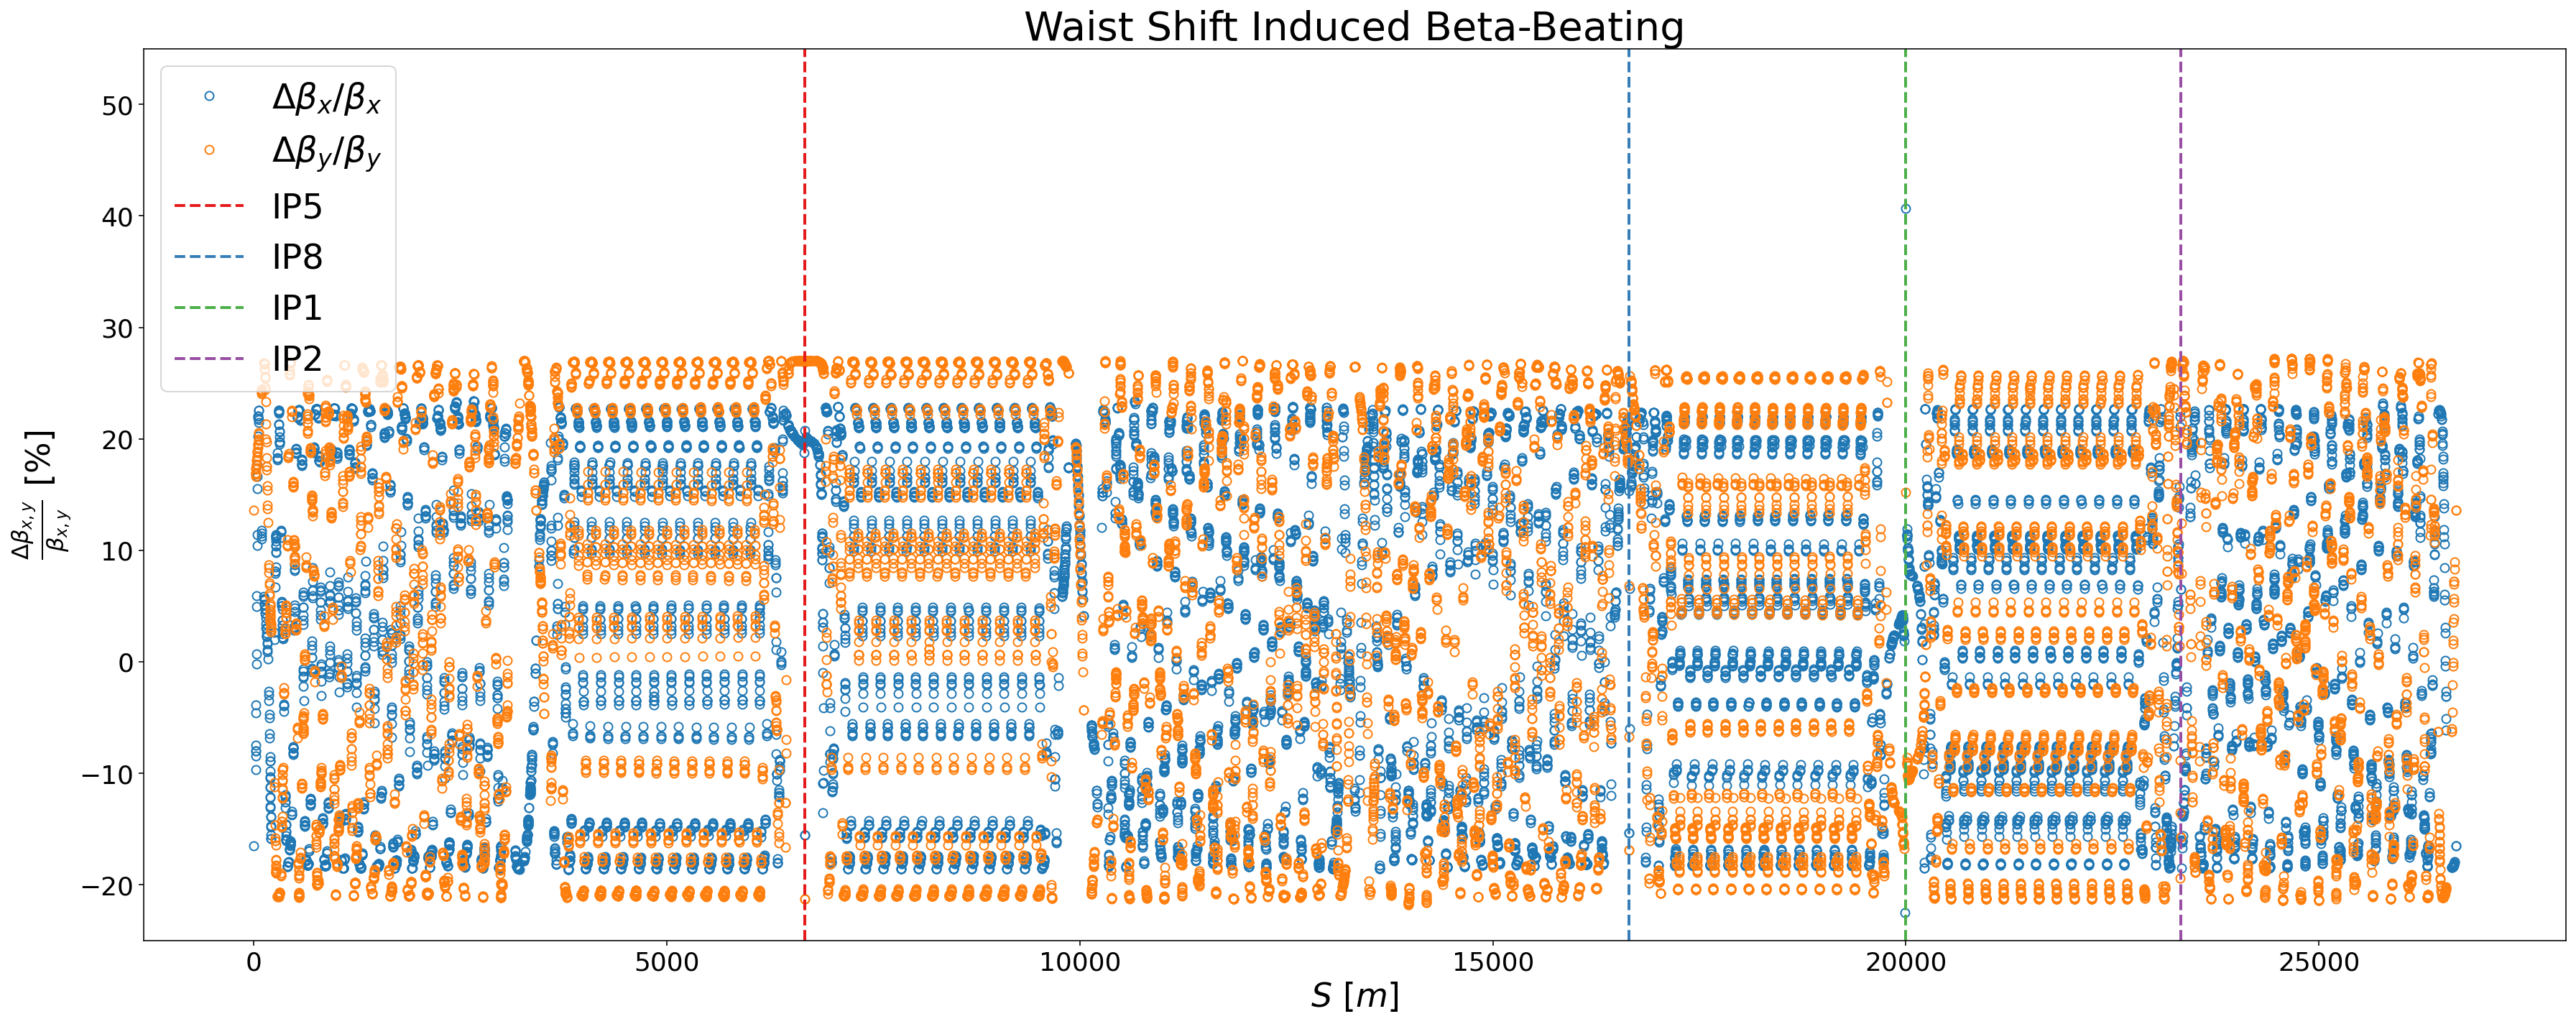

In [6]:
fig, axis = plt.subplots(figsize=(25, 10))
plot_waist_shift_betabeatings(axis, twiss_bare_waist_shift, show_ips=True)
axis.set_ylim(-25, 55)
axis.set_title("Waist Shift Induced Beta-Beating")

# Improving Rigidity Waist Shift Knob by Preserving Conditions at Q3 and the Edge of IR1
---

- Choose target points: __at the edge of IR1__ (chosen: `Q11`) on both sides, __at IP1 exactly__ and __at Q3__.
- __At edge of IR1__, targets the $\beta_{x,y}$, $\mu_{x,y}$, $\alpha_{x,y}$ ($D_{x, y}$ too?) values these points have in `twiss_nominal`.
    - Something like `madx.command.constraint(sequence="lhcb1", range_="chosen_location", betx=target_betax_IR1_edge, bety=target_betay_IR1_edge)` commands


- __At IP1 exactly__, target the $\beta$ values from the application of the waist shift knob (query from `twiss_bare_waist_shift`) ($\alpha_{x,y}$ too, $D_{x,y}$ dpx etc should be 0)
    - Something like `madx.command.constraint(sequence="lhcb1", range_="IP1", betx=betax_IP1_with_waist, bety=betay_IP1_with_waist)` commands


- Give vary knobs using all individually powered quadrupoles after triplets (Q4 to Q11, Q12 maybe), with constraints on their powerings
    - Something like `madx.command.vary(name="kq4.l1b1", step=1.0e-6, lower="-mqy.4l1.b1->kmax/brho", upper="+mqy.4l1.b1->kmax/brho")` commands


- Do __Jacobian / LMDIF__ calls


Eventually if too difficult we give up phase advance matching (directly this is tune), and use MQTs to match this back (they're designed to have very small betabeating).
we don't care so much where errors come from (triplet, feeddown etc) as long as we can accurately correct it. For ML one very nice thing could be to try and identify where the sources for some specific errors are. If a model can do that we could find better ways to mitigate it. This could be a natural next step.

### Start by doing matching with only $\beta$ constraints first to help Jacobian

In [7]:
# Positions at which to match to nominal conditions
MATCH_LEFT = "MQ.11L1.B1"  # Q11 left
MATCH_RIGHT = "MQ.11R1.B1"  # Q11 right

MATCH_Q3_LEFT = "MQXA.3L1"  # Q3 left
MATCH_Q3_RIGHT = "MQXA.3L1"  # Q3 right

In [8]:
# JACOBIAN matching to nominal beta and dispersion functions
# TODO: parametrize from IP (1/5)
# TODO: parametrize from BEAM (1/2)
# TODO: make use of MATCH_Q3_[LEFT/RIGHT]
madx.command.match(sequence="lhcb1", chrom=True)
madx.command.constraint(
    sequence="lhcb1", range_="IP1", betx=twiss_bare_waist_shift.BETX["IP1"], bety=twiss_bare_waist_shift.BETY["IP1"], dx=0, dy=0
)
madx.command.constraint(sequence="lhcb1", range_=MATCH_LEFT.upper(), betx=twiss_nominal.BETX[MATCH_LEFT], bety=twiss_nominal.BETY[MATCH_LEFT])
madx.command.constraint(sequence="lhcb1", range_=MATCH_RIGHT.upper(), betx=twiss_nominal.BETX[MATCH_RIGHT], bety=twiss_nominal.BETY[MATCH_RIGHT])
lhc.vary_independent_ir_quadrupoles(madx, quad_numbers=list(range(4, 11)), sides=("r", "l"), ip=1, beam=1)  # Q4 to Q10 included
madx.command.jacobian(calls=500, strategy=3, tolerance=1.0e-21)
# madx.command.lmdif(calls=100, tolerance=1.0e-21)
madx.command.endmatch()

# Should use MQTs (minimal beta-beating impact) to get back to working point in case of drift
matching.match_tunes_and_chromaticities(madx, "lhc", "lhcb1", 62.31, 60.32, 2.0, 2.0, calls=200, telescopic_squeeze=True)

2022-02-28 20:55:13 | INFO     | pyhdtoolkit.cpymadtools.matching:187 - Doing combined matching to Qx=62.31, Qy=60.32, dqx=2.0, dqy=2.0 for sequence 'lhcb1'


### Now do matching with all constraints

In [9]:
# Then one with also alphas
madx.command.match(sequence="lhcb1", chrom=True)
madx.command.constraint(
    sequence="lhcb1",
    range_="IP1",
    betx=twiss_bare_waist_shift.BETX["IP1"],
    bety=twiss_bare_waist_shift.BETY["IP1"],
    alfx=twiss_bare_waist_shift.ALFX["IP1"],
    alfy=twiss_bare_waist_shift.ALFY["IP1"],
    dx=0,
    dy=0,
)
madx.command.constraint(
    sequence="lhcb1",
    range_=MATCH_LEFT.upper(),
    betx=twiss_nominal.BETX[MATCH_LEFT],
    bety=twiss_nominal.BETY[MATCH_LEFT],
    alfx=twiss_nominal.ALFX[MATCH_LEFT],
    alfy=twiss_nominal.ALFY[MATCH_LEFT],
    dx=twiss_nominal.DX[MATCH_LEFT],
    dy=twiss_nominal.DY[MATCH_LEFT],
)
madx.command.constraint(
    sequence="lhcb1",
    range_=MATCH_RIGHT.upper(),
    betx=twiss_nominal.BETX[MATCH_RIGHT],
    bety=twiss_nominal.BETY[MATCH_RIGHT],
    alfx=twiss_nominal.ALFX[MATCH_RIGHT],
    alfy=twiss_nominal.ALFY[MATCH_RIGHT],
    dx=twiss_nominal.DX[MATCH_RIGHT],
    dy=twiss_nominal.DY[MATCH_RIGHT],
)
lhc.vary_independent_ir_quadrupoles(madx, quad_numbers=list(range(4, 11)), sides=("r", "l"), ip=1, beam=1)  # Q4 to Q10 included
madx.command.jacobian(calls=1000, strategy=3, tolerance=1.0e-21)
# madx.command.lmdif(calls=100, tolerance=1.0e-21)
madx.command.endmatch()

# Should use MQTs (minimal beta-beating impact) to get back to working point in case of drift
matching.match_tunes_and_chromaticities(madx, "lhc", "lhcb1", 62.31, 60.32, 2.0, 2.0, calls=200, telescopic_squeeze=True)

++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


2022-02-28 20:55:44 | INFO     | pyhdtoolkit.cpymadtools.matching:187 - Doing combined matching to Qx=62.31, Qy=60.32, dqx=2.0, dqy=2.0 for sequence 'lhcb1'


In [10]:
get_triplets_powering_knobs(madx, ip=1)

{'kqx.r1': 0.00870595583172255, 'kqx.l1': -0.008793452875257448}

In [11]:
get_independent_quadrupoles_powering_knobs(madx, quad_numbers=list(range(4, 11)), ip=1, beam=1)

{'kq4.r1b1': -0.0022172989611820015,
 'kq4.l1b1': 0.00208933948722707,
 'kq5.r1b1': 0.0011093136279236306,
 'kq5.l1b1': -0.0012459041982523674,
 'kq6.r1b1': -0.00039546311605330757,
 'kq6.l1b1': 0.0005673748206388833,
 'kq7.r1b1': 0.007534251169788316,
 'kq7.l1b1': -0.007783721119246084,
 'kq8.r1b1': -0.007297805694456366,
 'kq8.l1b1': 0.007978427295661594,
 'kq9.r1b1': 0.006621411762696707,
 'kq9.l1b1': -0.0065257934018004785,
 'kq10.r1b1': -0.00663675354829373,
 'kq10.l1b1': 0.007016619072760918}

In [12]:
twiss_after_matching = twiss.get_twiss_tfs(madx)
twiss_after_matching["BBX"] = betabeating(twiss_nominal.BETX, twiss_after_matching.BETX)
twiss_after_matching["BBY"] = betabeating(twiss_nominal.BETY, twiss_after_matching.BETY)

2022-02-28 20:55:51 | INFO     | pyhdtoolkit.cpymadtools.twiss:121 - Exporting internal TWISS and SUMM tables to TfsDataFrame


Text(0.5, 1.0, 'Waist Shift Induced Beta-Beating, After Matching')

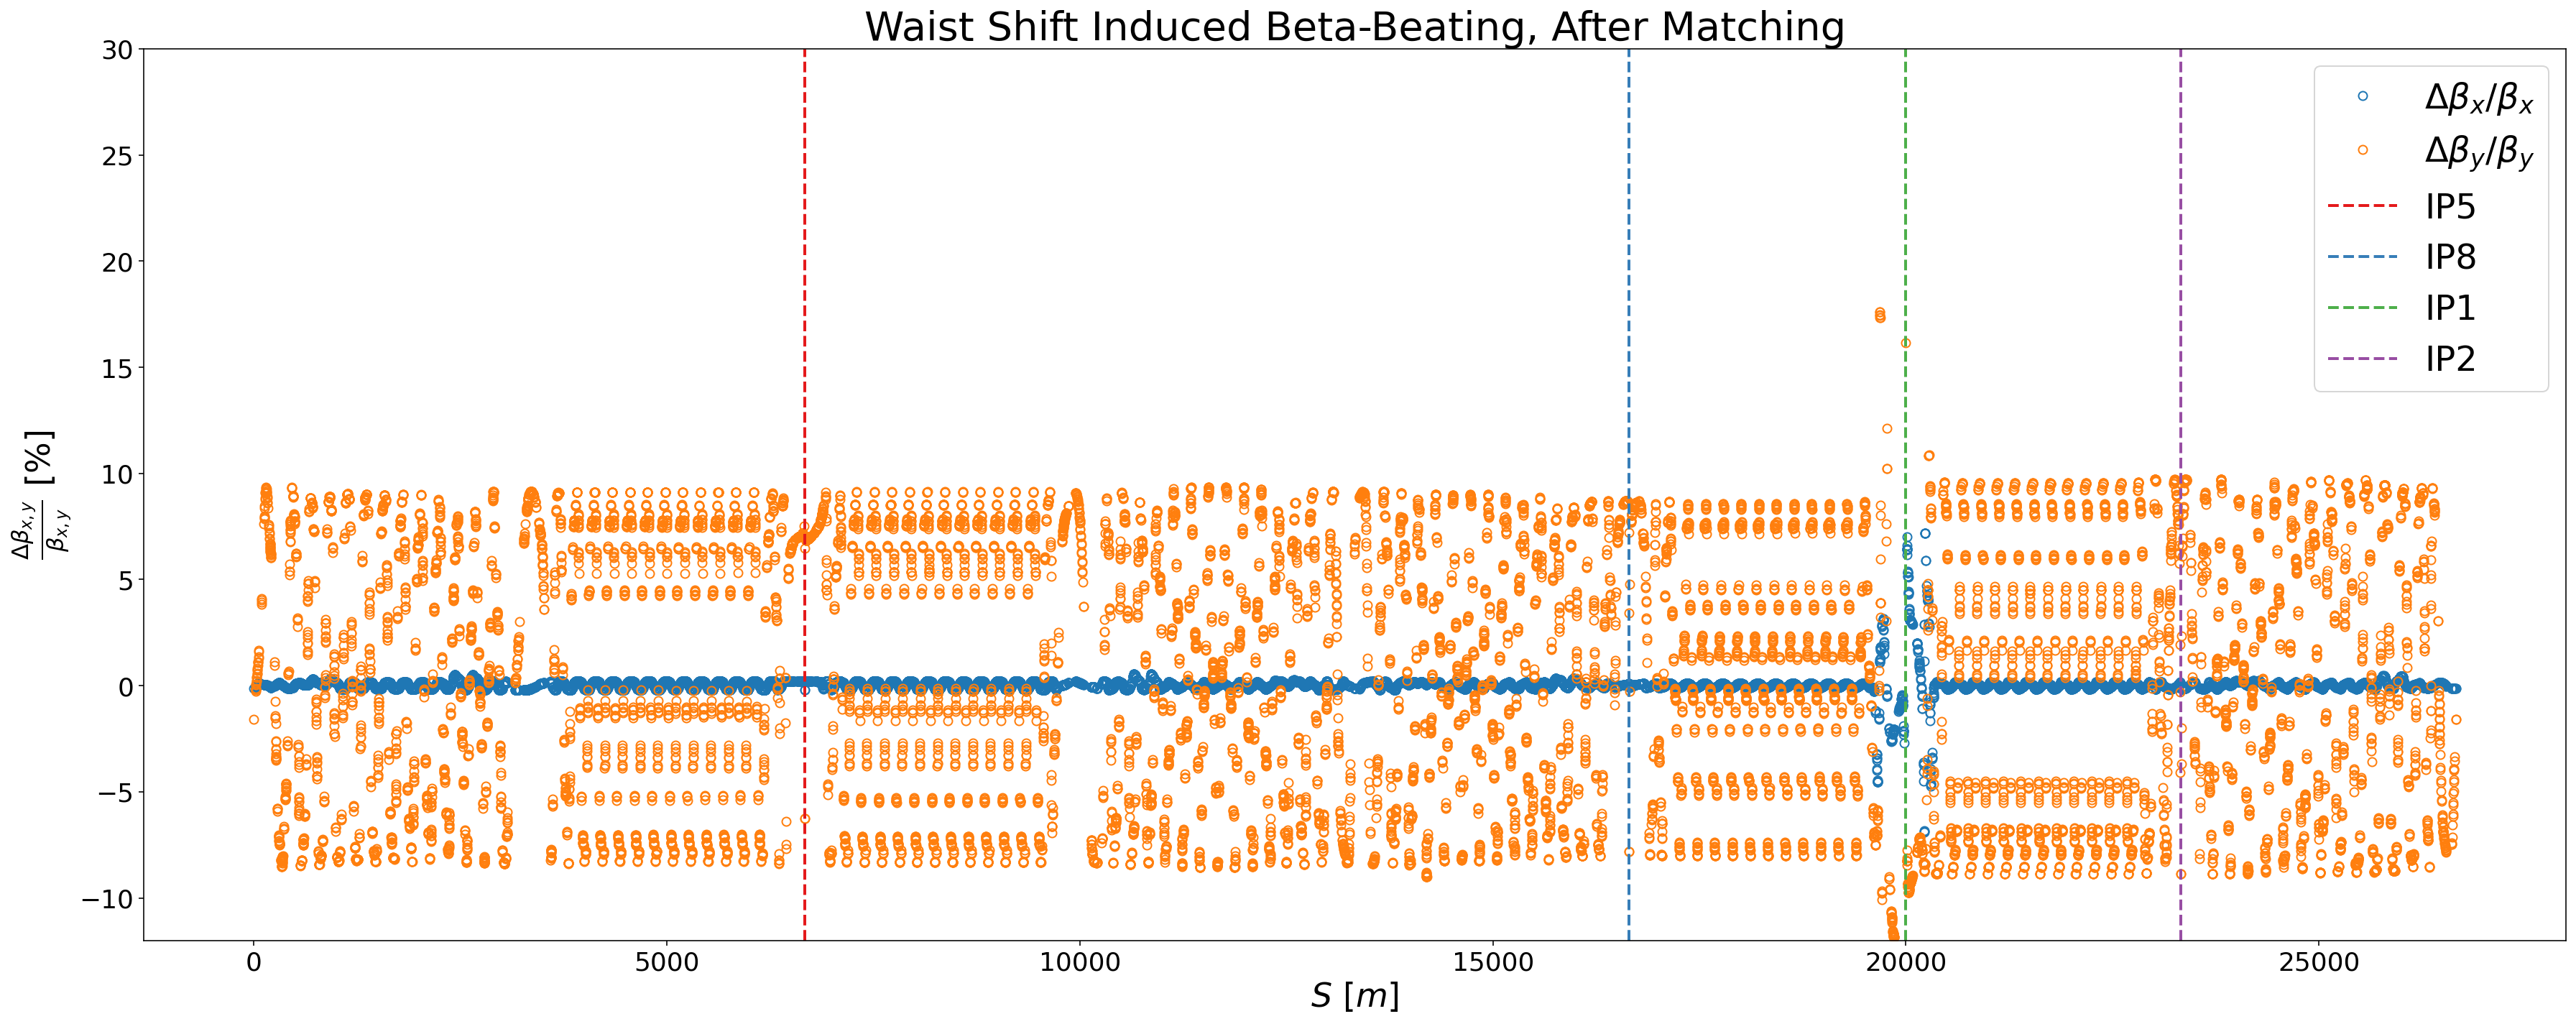

In [13]:
fig, axis = plt.subplots(figsize=(25, 10))
plot_waist_shift_betabeatings(axis, twiss_after_matching, show_ips=True)
axis.set_ylim(-12, 30)
axis.set_title("Waist Shift Induced Beta-Beating, After Matching")

## Plotting

(-30.0, 50.0)

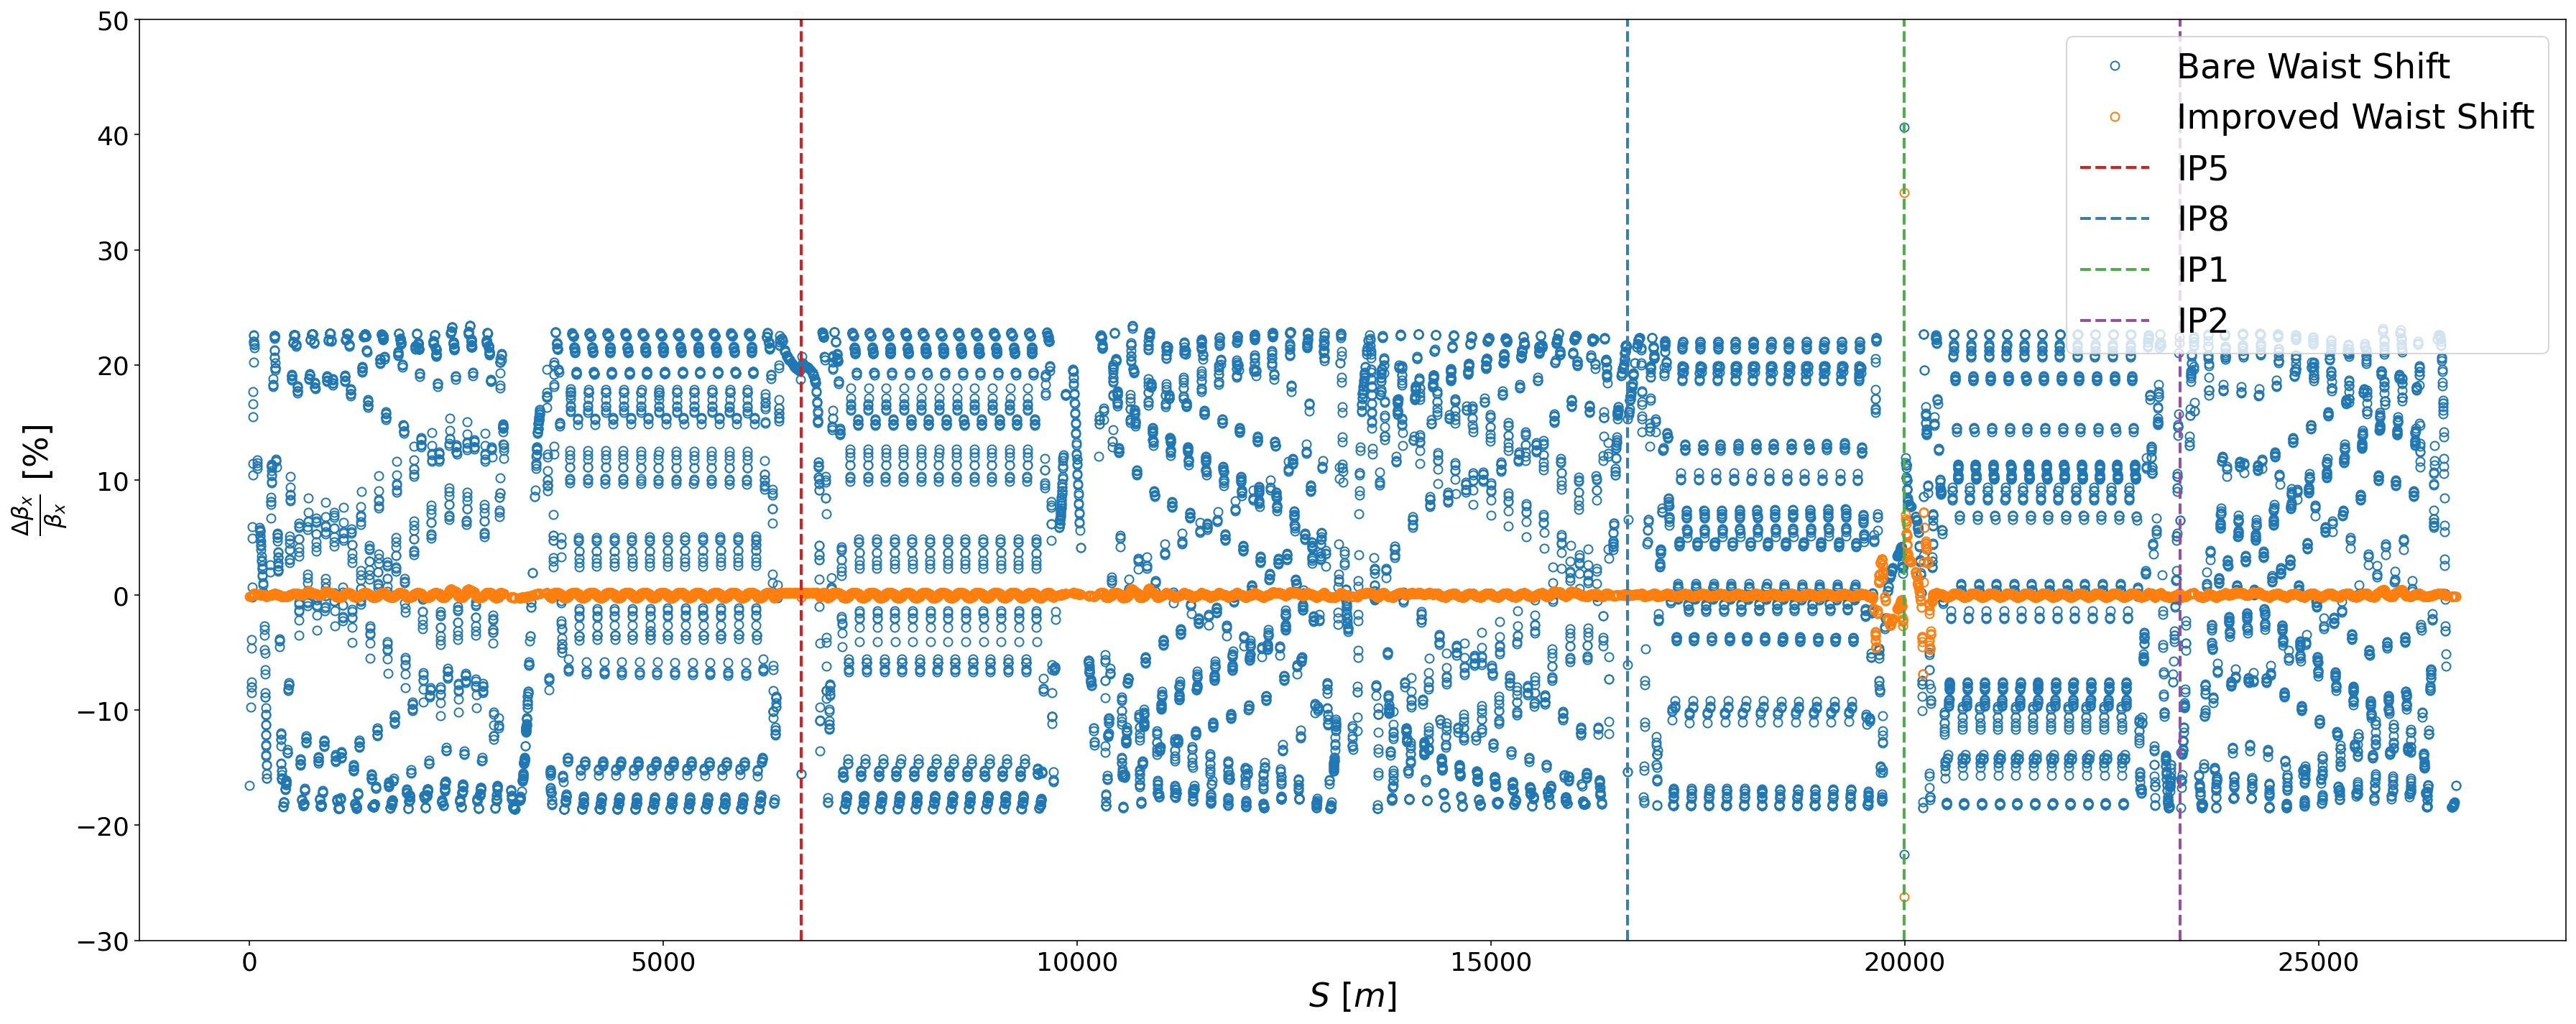

In [14]:
fig, axis = plt.subplots(figsize=(25, 10))
plot_waist_shift_betabeatings_comparison(axis, twiss_bare_waist_shift, twiss_after_matching, column="BBX", show_ips=True)
axis.set_ylim(-30, 50)

Text(0.5, 0, 'S [m]')

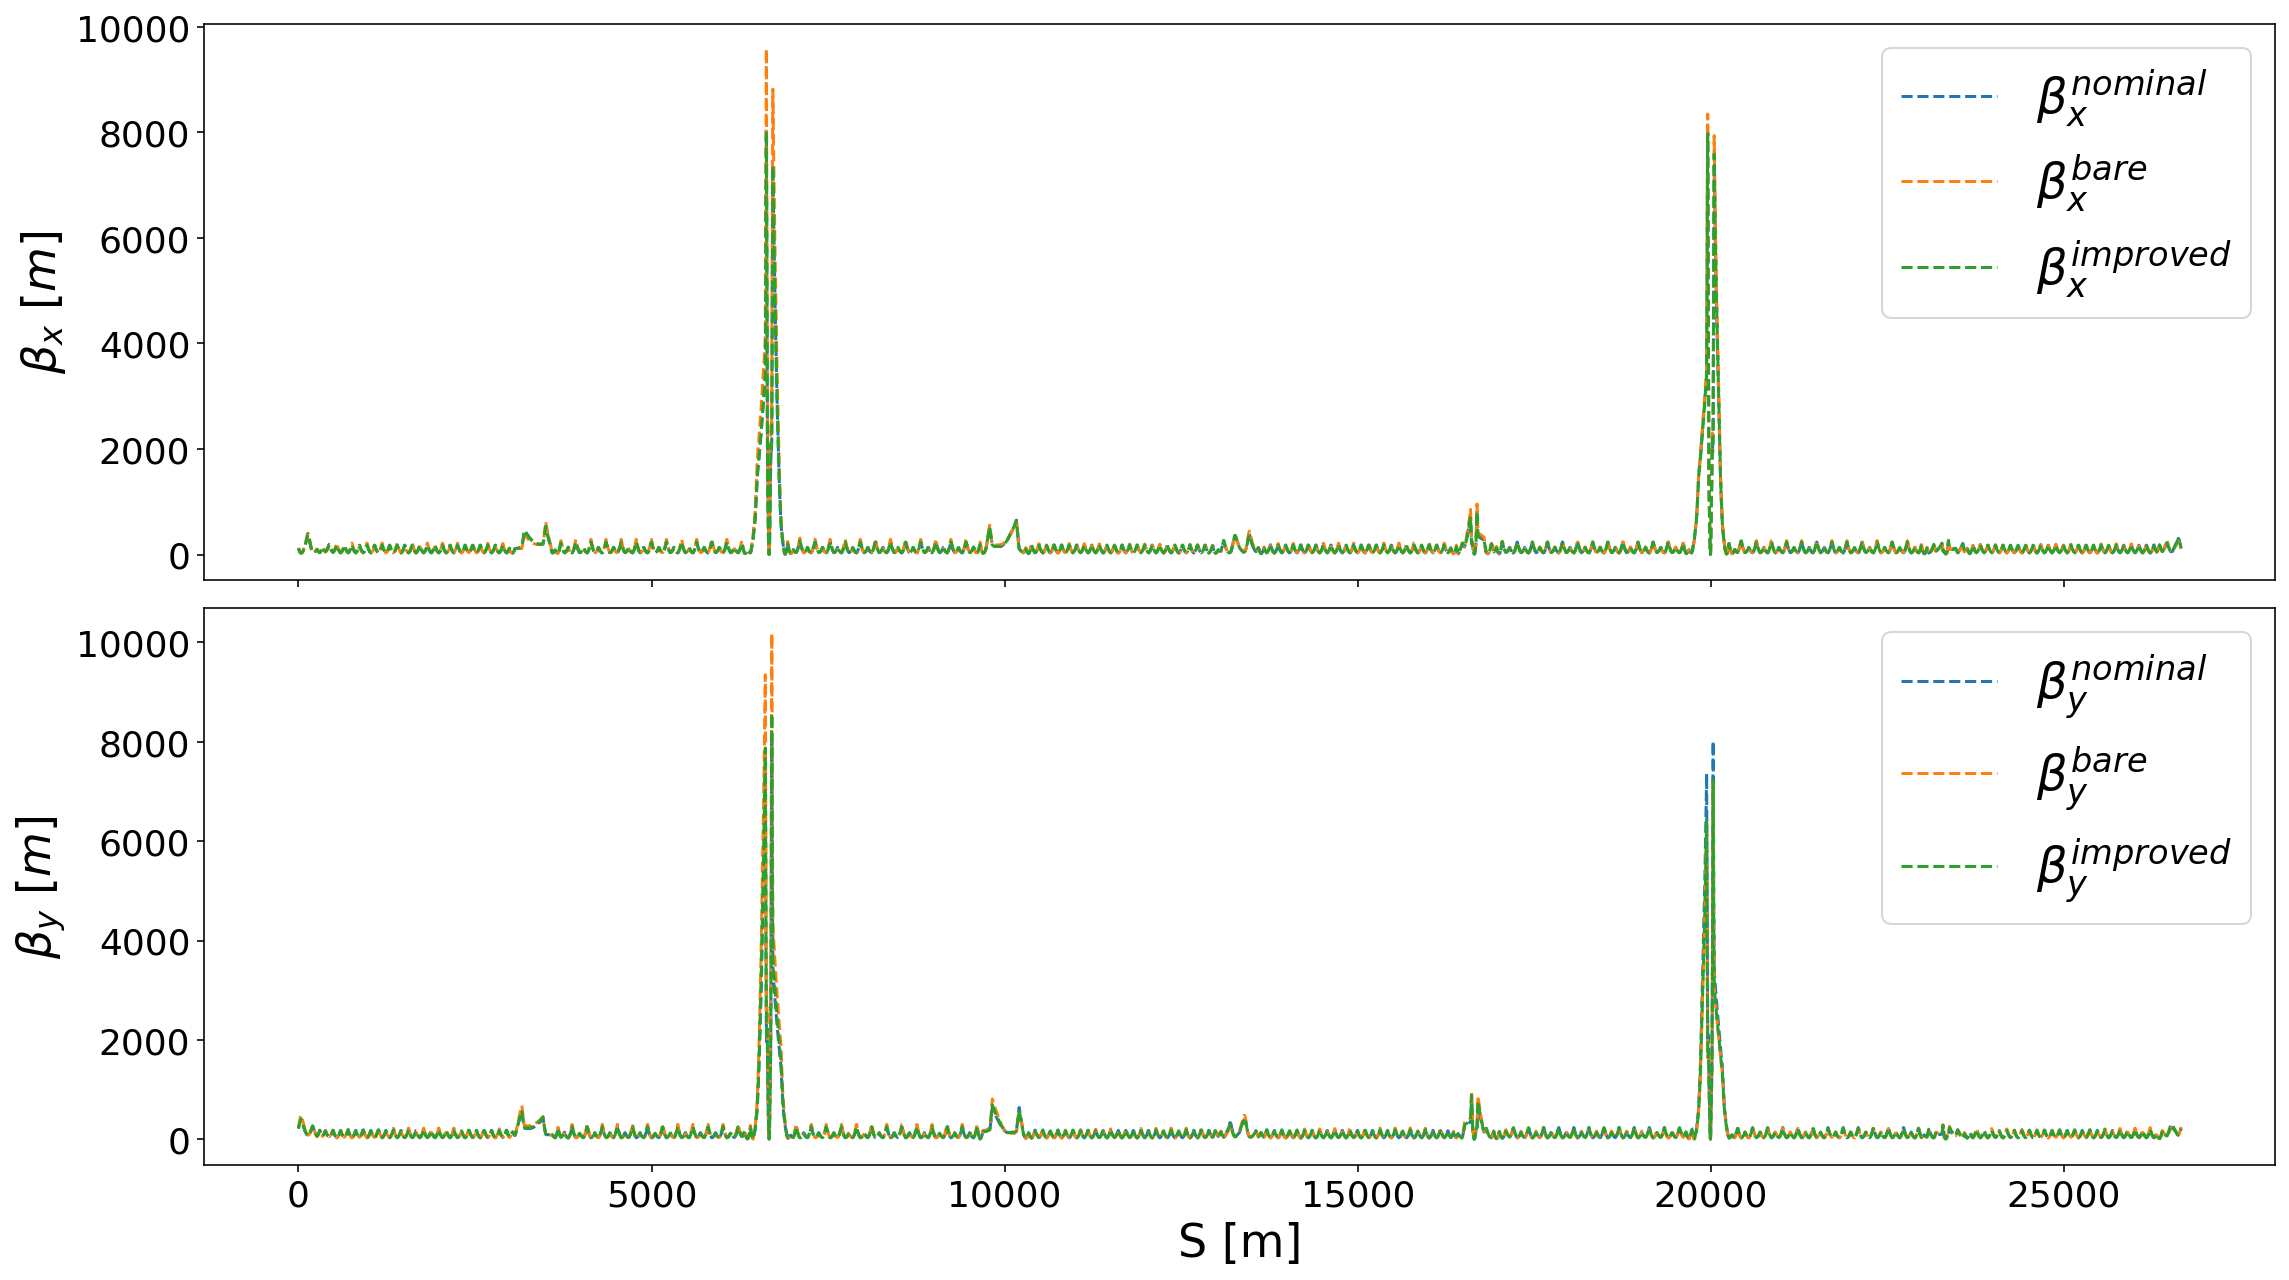

In [15]:
fig, (axx, axy) = plt.subplots(2, 1, figsize=(16, 9), sharex=True)

plot_betas_comparison(axx, twiss_nominal, twiss_bare_waist_shift, twiss_after_matching, column="BETX")
plot_betas_comparison(axy, twiss_nominal, twiss_bare_waist_shift, twiss_after_matching, column="BETY")
axy.set_xlabel("S [m]")
# axx.set_xlim(19500, 20500)

Text(0.5, 0, 'S [m]')

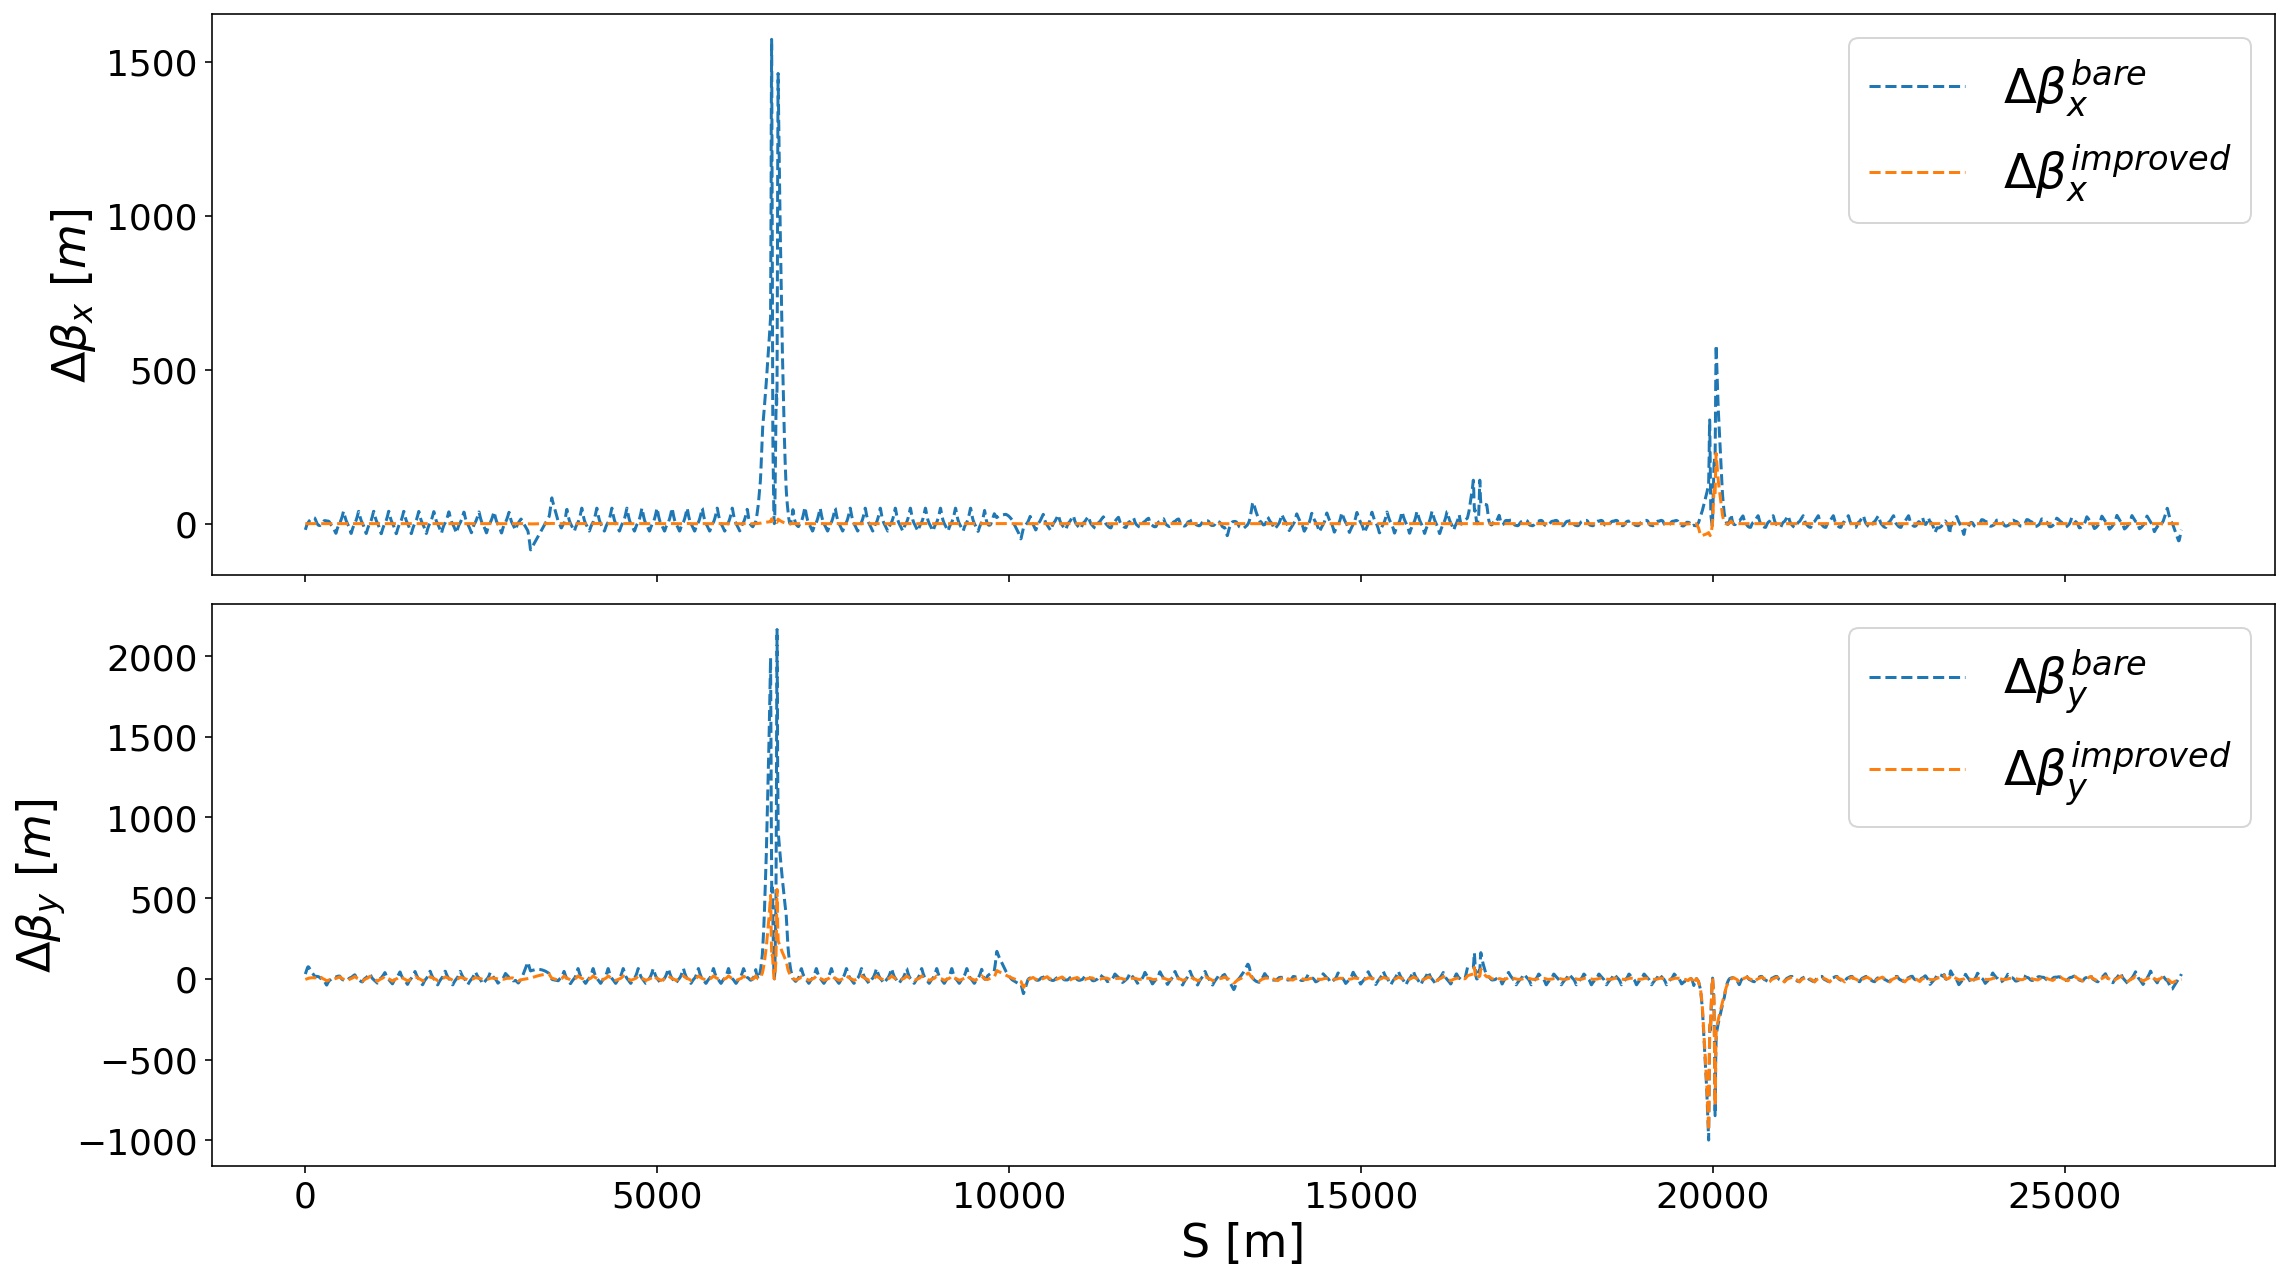

In [16]:
# Also get nominal with twiss.get_twiss_tfs(madx) to make things the same
fig, (axx, axy) = plt.subplots(2, 1, figsize=(16, 9), sharex=True)

plot_betas_deviation(axx, twiss_nominal, twiss_bare_waist_shift, twiss_after_matching, column="BETX")
plot_betas_deviation(axy, twiss_nominal, twiss_bare_waist_shift, twiss_after_matching, column="BETY")
axy.set_xlabel("S [m]")
# axx.set_xlim(19500, 20500)

Text(0.5, 0, 'S [m]')

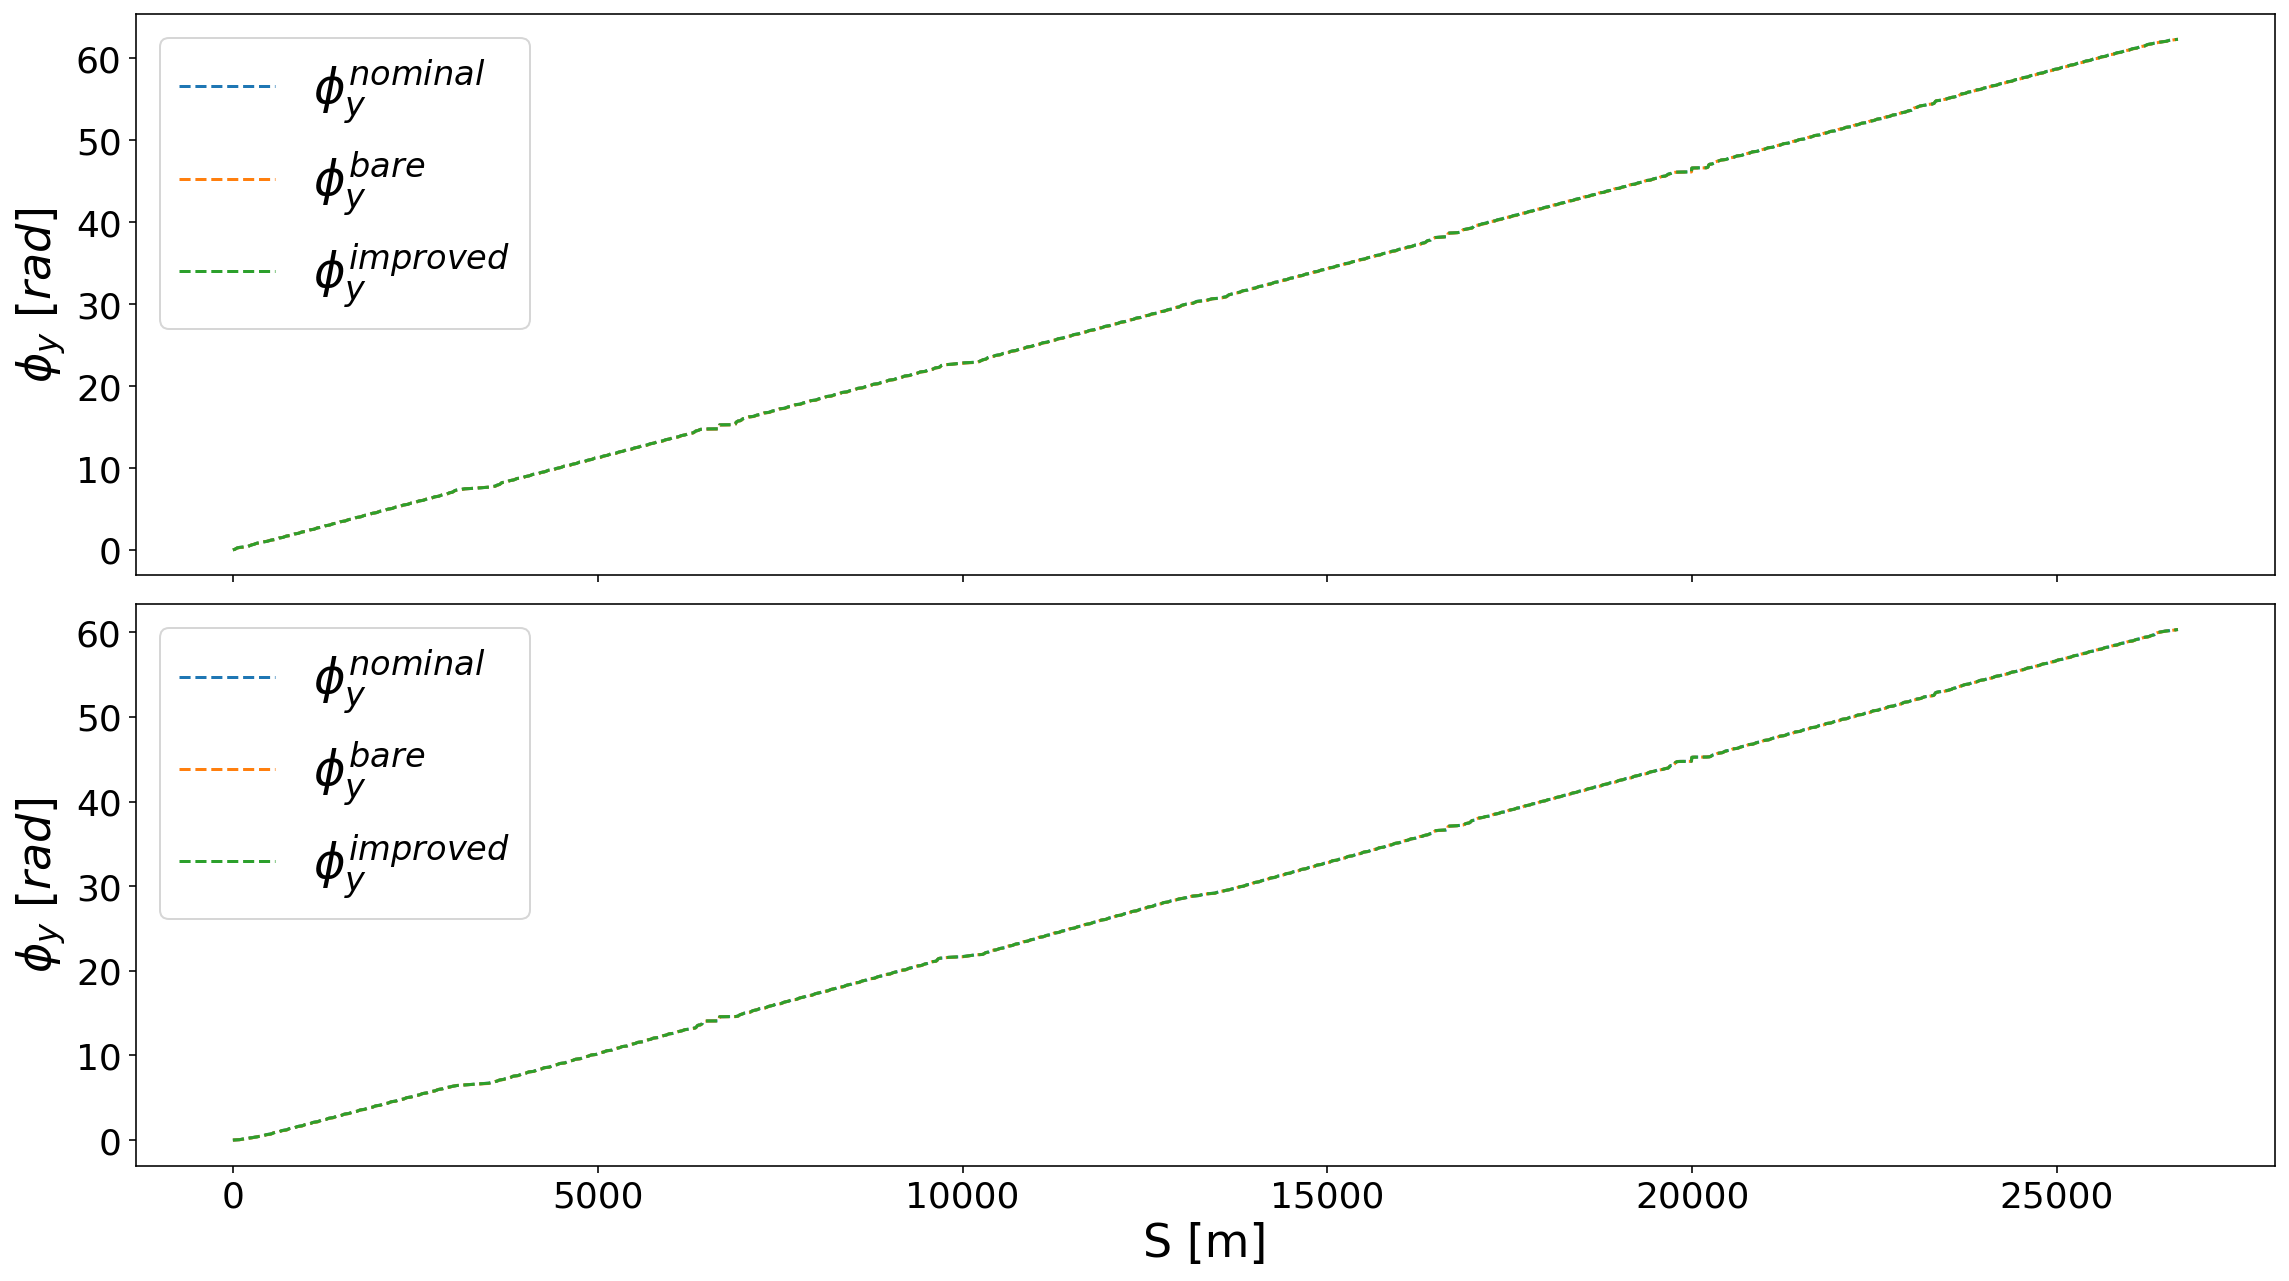

In [17]:
fig, (axx, axy) = plt.subplots(2, 1, figsize=(16, 9), sharex=True)

plot_phase_advances_comparison(axx, twiss_nominal, twiss_bare_waist_shift, twiss_after_matching, column="MUX")
plot_phase_advances_comparison(axy, twiss_nominal, twiss_bare_waist_shift, twiss_after_matching, column="MUY")
axy.set_xlabel("S [m]")

Text(0.5, 0, 'S [m]')

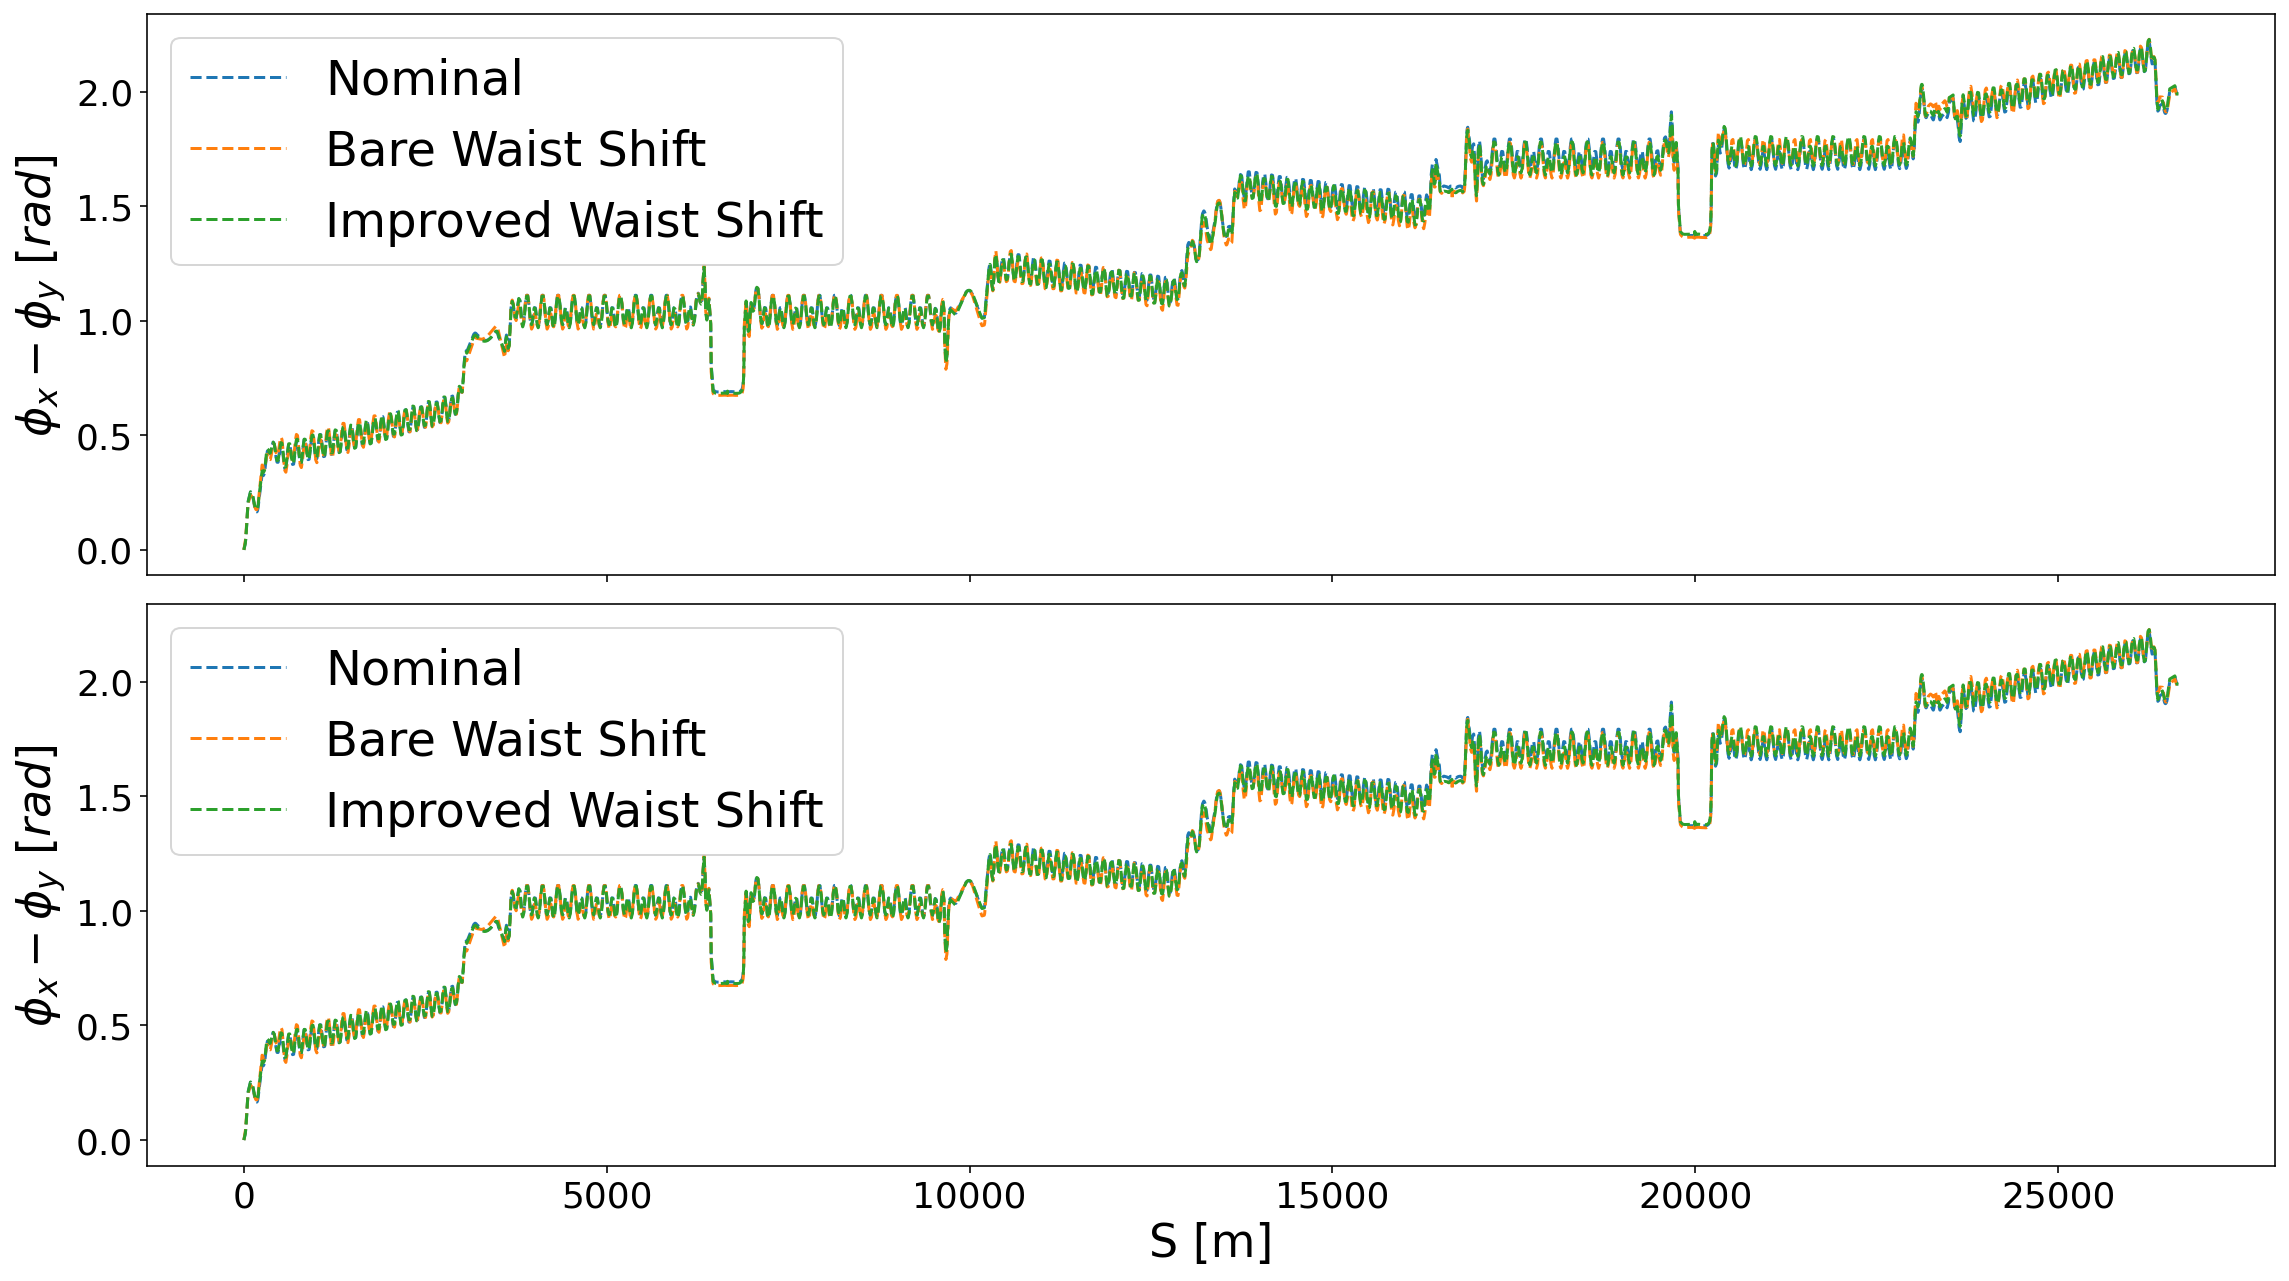

In [18]:
fig, (axx, axy) = plt.subplots(2, 1, figsize=(16, 9), sharex=True)

plot_phase_differences(axx, twiss_nominal, twiss_bare_waist_shift, twiss_after_matching)
plot_phase_differences(axy, twiss_nominal, twiss_bare_waist_shift, twiss_after_matching)
axy.set_xlabel("S [m]")

---

In [19]:
powering_tfs = twiss.get_twiss_tfs(madx)
ip1s = powering_tfs.S["IP1"]
powering_tfs = powering_tfs.loc[powering_tfs.S.between(ip1s - 457, ip1s + 457)]
powering_tfs = powering_tfs.loc[powering_tfs.KEYWORD == "quadrupole"]
powering_tfs["K1"] = powering_tfs.K1L / powering_tfs.L
powering_tfs = powering_tfs[["K1", "K1L"]]
powering_tfs = powering_tfs.drop(
    index=[
        "MQTLI.11L1.B1",
        "MQTLI.11R1.B1",
        "MQ.11L1.B1",
        "MQ.11R1.B1",
        "MQXB.A2L1",
        "MQXB.A2R1",
        "MQXB.B2L1",
        "MQXB.B2R1",
        "MQSX.3L1",
        "MQSX.3R1",
        "MQXA.3L1",
        "MQXA.3R1",
    ]
)
powering_tfs

# print(powering_tfs.to_latex())

2022-02-28 20:55:53 | INFO     | pyhdtoolkit.cpymadtools.twiss:121 - Exporting internal TWISS and SUMM tables to TfsDataFrame


Headers:
    LENGTH: 26658.883199999043
    ORBIT5: -0.0
    ALFA: 0.0003484773631318951
    ...
    NFLIPS: 0.0
    DQMIN: 0.0
    DQMIN_PHASE: 0.0

                    K1       K1L
NAME                            
MQML.10L1.B1  0.007017  0.033680
MQMC.9L1.B1  -0.006526 -0.015662
MQM.9L1.B1   -0.006526 -0.022188
MQML.8L1.B1   0.007978  0.038296
MQM.B7L1.B1  -0.007784 -0.026465
MQM.A7L1.B1  -0.007784 -0.026465
MQML.6L1.B1   0.000567  0.002723
MQML.5L1.B1  -0.001246 -0.005980
MQY.4L1.B1    0.002089  0.007104
MQXA.1L1     -0.008721 -0.055552
MQXA.1R1      0.008633  0.054995
MQY.4R1.B1   -0.002217 -0.007539
MQML.5R1.B1   0.001109  0.005325
MQML.6R1.B1  -0.000395 -0.001898
MQM.A7R1.B1   0.007534  0.025616
MQM.B7R1.B1   0.007534  0.025616
MQML.8R1.B1  -0.007298 -0.035029
MQMC.9R1.B1   0.006621  0.015891
MQM.9R1.B1    0.006621  0.022513
MQML.10R1.B1 -0.006637 -0.031856

In [20]:
madx.exit()

---

- Plot the global phase advance in each case too (mux/muy versus S)
- Can also do mux - muy because it drives the f1001

At the end:
- have the better waist shift in
- put in a little bit of crossing angles and see that the orbit starts changing
- try to do a bit of correction (`CORRECT` in madx)

Caveat: would have to disable the use of the crossing angle correctors knobs